In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas as pd
import keras
from keras.optimizers import Adam

2023-10-18 15:43:27.447483: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 15:43:27.447541: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 15:43:27.447565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 15:43:28.505356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minve

In [3]:
od.download("https://www.kaggle.com/datasets/gonzajl/neumona-x-rays-dataset")

Skipping, found downloaded files in "./neumona-x-rays-dataset" (use force=True to force download)


In [4]:
datos = pd.read_csv('neumona-x-rays-dataset/dataset/datos.csv')

In [5]:
datos

,imagen,neumonia,no_neumonia
0,dataset/neumonia/PNEUMONIA_3336.jpeg,1,0
1,dataset/no-neumonia/NORMAL2-IM-1149-0001.jpeg,0,1
2,dataset/no-neumonia/NORMAL_2030.jpeg,0,1
3,dataset/neumonia/PNEUMONIA_2178.jpeg,1,0
4,dataset/neumonia/BACTERIA-7720431-0001.jpeg,1,0
...,...,...,...
10493,dataset/no-neumonia/IM-0501-0001.jpeg,0,1
10494,dataset/neumonia/person1921_bacteria_4828.jpeg,1,0
10495,dataset/neumonia/PNEUMONIA_1185.jpeg,1,0
10496,dataset/no-neumonia/IM-0455-0001.jpeg,0,1


In [8]:
def cargar_imagenes(nombres, et):
    imagenes = []
    etiquetas = []
    for i in range(len(nombres)):
        ruta = 'neumona-x-rays-dataset/' + nombres[i]
        imagen = cv2.imread(ruta, cv2.IMREAD_COLOR)
        imagenes.append(imagen)
        etiquetas.append(list(et.iloc[i]))
    return imagenes, etiquetas

In [9]:
datos

,imagen,neumonia,no_neumonia
0,dataset/neumonia/PNEUMONIA_3336.jpeg,1,0
1,dataset/no-neumonia/NORMAL2-IM-1149-0001.jpeg,0,1
2,dataset/no-neumonia/NORMAL_2030.jpeg,0,1
3,dataset/neumonia/PNEUMONIA_2178.jpeg,1,0
4,dataset/neumonia/BACTERIA-7720431-0001.jpeg,1,0
...,...,...,...
10493,dataset/no-neumonia/IM-0501-0001.jpeg,0,1
10494,dataset/neumonia/person1921_bacteria_4828.jpeg,1,0
10495,dataset/neumonia/PNEUMONIA_1185.jpeg,1,0
10496,dataset/no-neumonia/IM-0455-0001.jpeg,0,1


In [10]:
paths = datos.iloc[:, 0]
tags = datos.iloc[:, 1:]   #ignoro filas particulares y traigo las columnas de 1 a fin

In [11]:
imagenes, etiquetas = cargar_imagenes(paths, tags)

In [12]:
def mostrar_grafico_clases(etiquetas):
    cant_neumonia = etiquetas.count([1, 0])
    cant_no_neumonia = etiquetas.count([0, 1])

    categorias = ['neumonia', 'no_neumonia']
    cantidades = [cant_neumonia, cant_no_neumonia]

    plt.figure(figsize=(6, 4))
    barras = plt.bar(categorias, cantidades)

    for bar, cantidad in zip(barras, cantidades):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2, str(cantidad), fontsize=12)

    plt.xlabel('Clases')
    plt.ylabel('Cantidad de Imágenes')
    plt.title('Cantidad de Imágenes por Clase')

    plt.show()

In [13]:
div_test = int(len(imagenes) * 0.7)

In [14]:
imagenes_entrenamiento, imagenes_prueba = imagenes[:div_test], imagenes[div_test:]
etiquetas_entrenamiento, etiquetas_prueba = etiquetas[:div_test], etiquetas[div_test:]

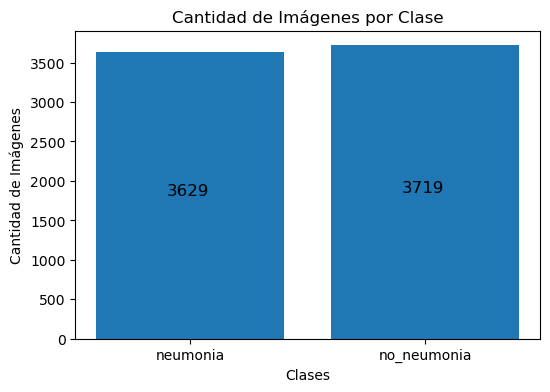

In [15]:
mostrar_grafico_clases(etiquetas_entrenamiento)

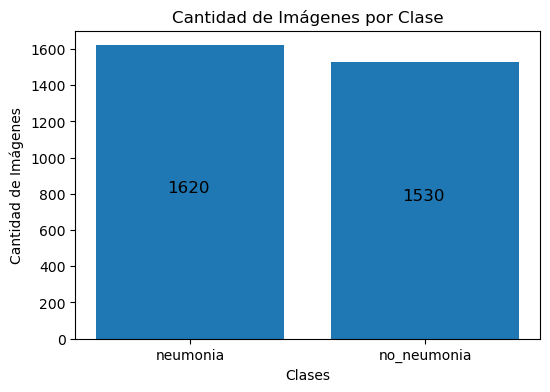

In [16]:
mostrar_grafico_clases(etiquetas_prueba)

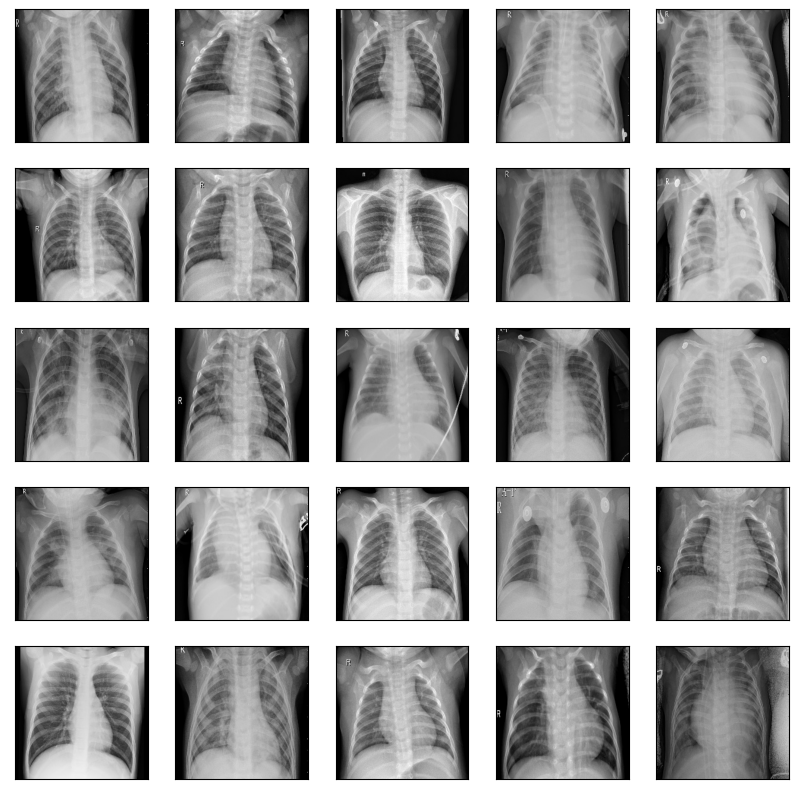

In [17]:
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagenes_entrenamiento[i])

plt.show()

In [18]:
# Normalización de entradas y conversión de listas a tensores
imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

In [19]:
xception = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

xception.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = xception(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [21]:
historial = model.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=20, validation_data=(imagenes_prueba, etiquetas_prueba))

Epoch 1/20


2023-10-18 15:44:04.214700: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4424318976 exceeds 10% of free system memory.


230/230 [==============================] - 348s 2s/step - loss: 0.2483 - categorical_accuracy: 0.9016 - val_loss: 0.1755 - val_categorical_accuracy: 0.9324
Epoch 2/20
230/230 [==============================] - 340s 1s/step - loss: 0.1185 - categorical_accuracy: 0.9577 - val_loss: 0.1088 - val_categorical_accuracy: 0.9616
Epoch 8/20
230/230 [==============================] - 347s 2s/step - loss: 0.1163 - categorical_accuracy: 0.9594 - val_loss: 0.1132 - val_categorical_accuracy: 0.9578
Epoch 9/20
230/230 [==============================] - 339s 1s/step - loss: 0.1093 - categorical_accuracy: 0.9618 - val_loss: 0.1055 - val_categorical_accuracy: 0.9594
Epoch 10/20
230/230 [==============================] - 344s 1s/step - loss: 0.1068 - categorical_accuracy: 0.9618 - val_loss: 0.1001 - val_categorical_accuracy: 0.9654
Epoch 11/20
230/230 [==============================] - 348s 2s/step - loss: 0.1046 - categorical_accuracy: 0.9623 - val_loss: 0.1063 - val_categorical_accuracy: 0.9575
Epoch 1

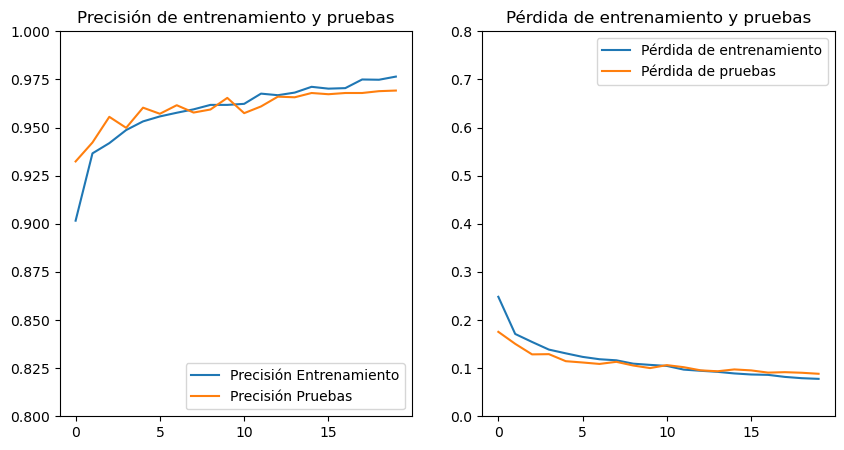

In [22]:
# Graficas de precisión y pérdida del modelo
categorical_accuracy = historial.history['categorical_accuracy']
val_categorical_accuracy = historial.history['val_categorical_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(20)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(rango_epocas, categorical_accuracy, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_categorical_accuracy, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.ylim(0.8, 1)
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label= 'Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.ylim(0, 0.8)
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [ ]:
def es_correcta(prediccion, esperado):
    return prediccion.index(max(prediccion)) == esperado.index(max(esperado))

In [ ]:
correctas_segun_tipo = [0, 0]
falladas_segun_tipo = [0, 0]

predicciones = model.predict(imagenes_prueba)
print(f"Cantidad de predicciones: {len(predicciones)}")

for i in range(len(predicciones)):
    prediccion = list(predicciones[i])
    index = prediccion.index(max(prediccion))
    
    if es_correcta(prediccion, list(etiquetas_prueba[i])):
        correctas_segun_tipo[index] += 1  
    else: 
        falladas_segun_tipo[index] += 1
        
cant_totales = list(map(lambda x, y: x + y, correctas_segun_tipo, falladas_segun_tipo))
print("Etiquetas:   [T, F]")
print(f"Total:       {cant_totales}")
print(f"Correctas:   {correctas_segun_tipo}")
print(f"Incorrectas: {falladas_segun_tipo}")

99/99 [==============================] - 102s 1s/step
Cantidad de predicciones: 3150
Etiquetas:   [T, F]
Total:       [1595, 1555]
Correctas:   [1559, 1494]
Incorrectas: [36, 61]
